# Computational Methods - Laboratories 9, Task 1 - Image processing, template matching using DFT.

## Theory
If an image is in greyscale, we can treat it as array, where every cell represents brightness of given pixel.
If we start with an source image of given size and given pattern, we can use the cross corelation method for template matching, which comes from the distance measure  (squared Euclidean distance):

$
d^2_{f,t}(u,v) = \sum_{x,y}[f(x,y) -t( x-u,y-v)]^2
$

(where $ f  $ is the image and the sum is over \( x,y \) under the window containing the feature $ t $ positioned at $ (u,v) $. In the expansion of $ d^2 $:

$
d^2_{f,t}(u,v) = \sum_{x,y}[f^2(x,y) - 2f(x,y)t(x-u,y-v) + t^2(x-u,y-v)]
$

the term $( \sum t^2(x-u,y-v) )$ is constant. If the term $( \sum f^2(x,y) )$ is approximately constant, then the remaining cross-correlation term:

$
c(u,v) = \sum_{x,y}f(x,y)t(x-u,y-v)  
$

is a measure of the similarity between the image and the feature.

There are several disadvantages to using this attitude for template matching:

1. If the image energy $ \sum f^2(x,y) $ varies with position, matching can fail. For example, the correlation between the feature and an exactly matching region in the image may be less than the correlation between the feature and a bright spot.

2. The range of $ c(u,v) $is dependent on the size of the feature.

3. It is not invariant for changes such as rotation of an image. 

### Computation and complexity:

For a search window of size $ M^2 $ and a feature of size $ N^2 $, equation (3) requires approximately $ N^2(M - N + 1)^2 $ additions and $ N^2(M - N + 1)^2 $ multiplications.

Following equation is a convolution of the image with the reversed feature (180 $\degree$ rotation) $ t'(x,y) = t(-x,-y) $ and can be computed by:

$
\mathcal{F}^{-1}\{ \mathcal{F}(f) \mathcal{F}^*(t') \} \quad (4)
$

where $ \mathcal{F} $ is the Fourier transform. 


Implementations of the FFT algorithm generally require that $ f' $ and $ t' $ be extended with zeros to a common power of two. The complexity of the transform computation (3) is then $ 12M^2 \log_2 M $ real multiplications and $ 18M^2 \log_2 M $ real additions/subtractions. When $ M $ is much larger than $ N $, the complexity of the direct 'spatial' computation  is approximately $ N^2M^2 $ multiplications/additions, and the direct method is faster than the transform method. The transform method becomes relatively more efficient as $ N $ approaches $ M $ and with larger $ M $, $ N $.

### Sources:
I've been reading a lot about Fourier transform, and it's use in OCR, but this theory fragment is to great extend adopted from :
[here](http://scribblethink.org/Work/nvisionInterface/nip.html)  
but i've been also using: [this](http://cs.boisestate.edu/~amit/mscs/samples/Jared_Hopkins_Project_Report.pdf) and [this](https://home.agh.edu.pl/~zobmat/2020/II_mich_mar/transformacje.html)

### Imports:

In [2]:
import numpy as np
from numpy import rot90
from numpy.fft import fft2, ifft2
from PIL import Image, ImageOps

### Image preprocessing helper functions:

In [3]:
def scale(image, factor):
    return image.resize(np.array(image.size) * factor)

def convert_to_rgb(image_arr):
    return np.array([[(val, val, val) for val in row] for row in image_arr])

### Turning to grayscale and saving for later use

In [4]:
galia = Image.open('img/galia.png')
galia= ImageOps.invert(galia.convert("L"))
e_letter = Image.open('img/galia_e.png')
e_letter = ImageOps.invert(e_letter.convert("L"))


### Instructions:
This lovely text (written by Julius Cesar) is our source image (after the color invertion - we prefer our images to be rather dark, for reasons mentioned in theory..):

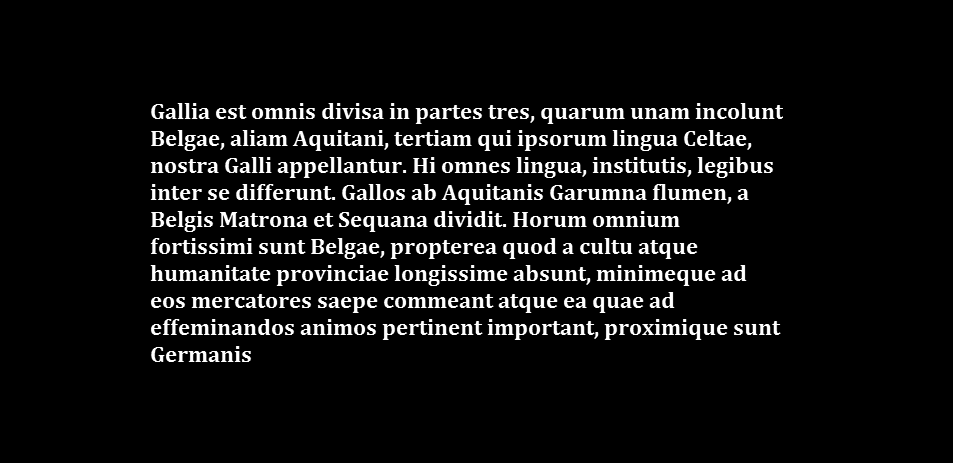

In [172]:
display(galia)

And our template is letter `e` :

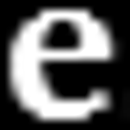

In [176]:
display(scale(e_letter,10))

### Since we are using Fourier Transform, we may extract information about:
1. Modulus (absolute value, distance from origin) of every value (complex number)
2. Phase (argument of complex number, it's angle)

In [5]:
def modulus_and_phase(image):
    img_fft = np.fft.fft2(np.asarray(image))

    #wyliczenie modułu liczb zespolonych (logarytm sluzy rozciagnieciu wartości)
    modulus = np.log(np.absolute(img_fft))

    #skalowanie do przedzialu [0-255]
    modulus /= np.max(modulus)
    modulus *= 255

    modulus = Image.fromarray(modulus)
    modulus = modulus.convert("RGB")

    #obliczanie fazy ( arg(z) )
    phase = np.angle(img_fft)

    #przesuwanie do przedziału [0-2pi]
    phase += np.pi 

    #skalowanie
    phase = phase * 255 / (2 * np.pi)

    
    phase = Image.fromarray(phase)
    phase = phase.convert("RGB")

    return modulus, phase

### Here you can look at it: (Why would you do it? )

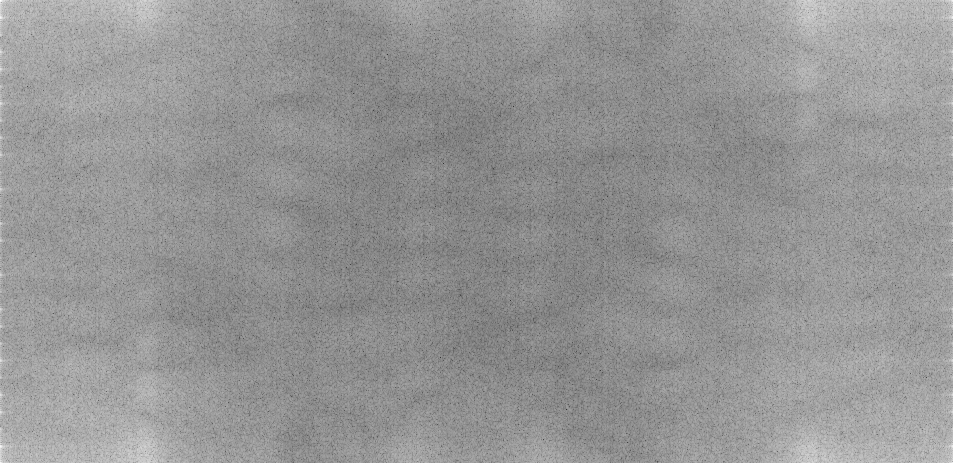

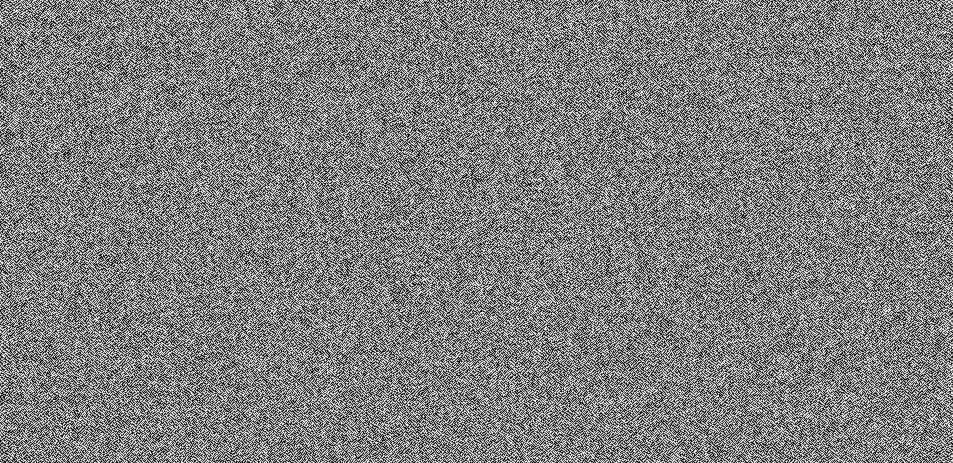

In [178]:
modulus, phase = modulus_and_phase(galia)
display(modulus)
display(phase)

### Calculation of correlation 
It is the very heart of this algorithm. It does exactly what was written in theory segment but additionally it normalizes it.

In [6]:
def calc_correlation(image, pattern):
    width, height = image.size
    
    correlation = ifft2( fft2(image) * fft2(rot90(pattern,2), s=(height, width)) )
    correlation = correlation.real 

    correlation /= np.abs(np.max(correlation))

    return correlation

Function for displaying the corelation as image:

In [7]:
def display_correlation(correlation):
    
    correlation /= np.max(correlation)
    correlation *= 255

    correlation_img = Image.fromarray(correlation)
    correlation_img = correlation_img.convert("RGB")

    display(correlation_img)

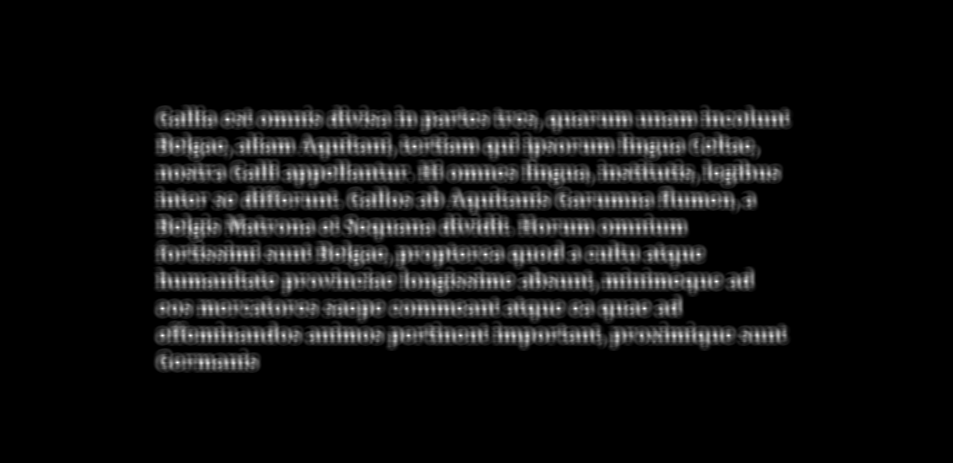

In [129]:
correlation = calc_correlation(galia, e_letter)

display_correlation(correlation)

As I mentioned in theory segment, obviously bright spots have much higher correlation thus, it looks just like blurred image. Hopefully though, the difference beetween random bright spot (another letters) and letter `e` even if not visible here, is enough to seperate it from other parts of the text 

### Function that finds given template and highlites it:
parameteres:
1. `image` - source image
2. `pattern` - template image
3. `certainty` - float between 0 and 1, specifies the rigour of our findings.
4. `selection_size` - values for higlihting, not important
5. `color` - color of higlighting. 

In [8]:
def find_pattern(image, pattern, certainty = 0.99, selection_size = (10, -15), color=(255, 0, 0)):

    correlation = calc_correlation(image,pattern)

    found = []
    for x in range(correlation.shape[0]):
        for y in range(correlation.shape[1]):
            if correlation[x, y] > certainty:
                found.append((x, y))


    image_arr = np.asarray(image)
    image_arr = convert_to_rgb(image_arr)
    result = image_arr.copy()
    for x, y in found:
        for dx in range(0, selection_size[0], np.sign(selection_size[0])):
            for dy in range(0, selection_size[1], np.sign(selection_size[1])):
                result[x + dx, y + dy] = color

    result = Image.fromarray(result)
    display(result)


### Let's test it:

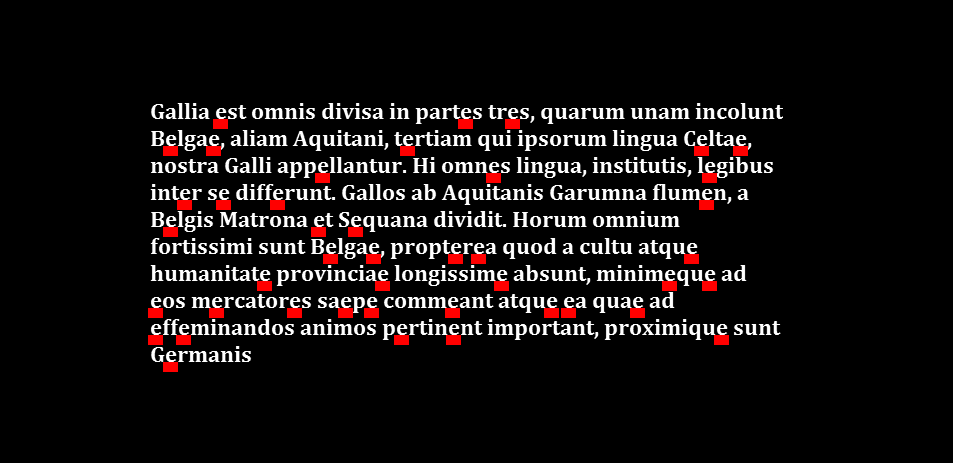

In [196]:
find_pattern(galia,e_letter,certainty=0.99)

### It does work! What a great success..
Let's try some other certainty levels:

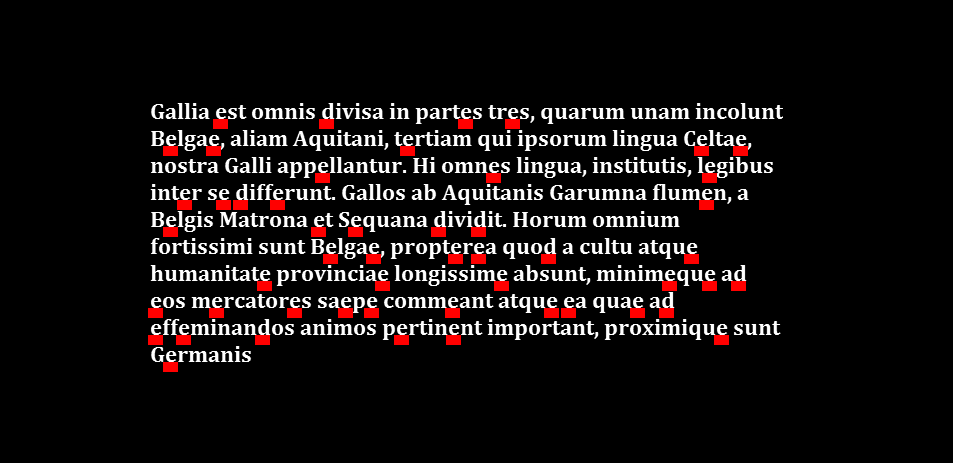

In [198]:
find_pattern(galia,e_letter,certainty=0.88)

The boundary for only `e` matches, and finding other letters (`d` is the most similair in tis case) lies between 0.88 and 0.89 certainty level

# NOW IT IS TIME FOR FISHES!
## Let's see how template matching using DFT will work for other images, not text.

### This is our source image (already in greyscale). This time, we do not reverse colours because it is already dark enough.

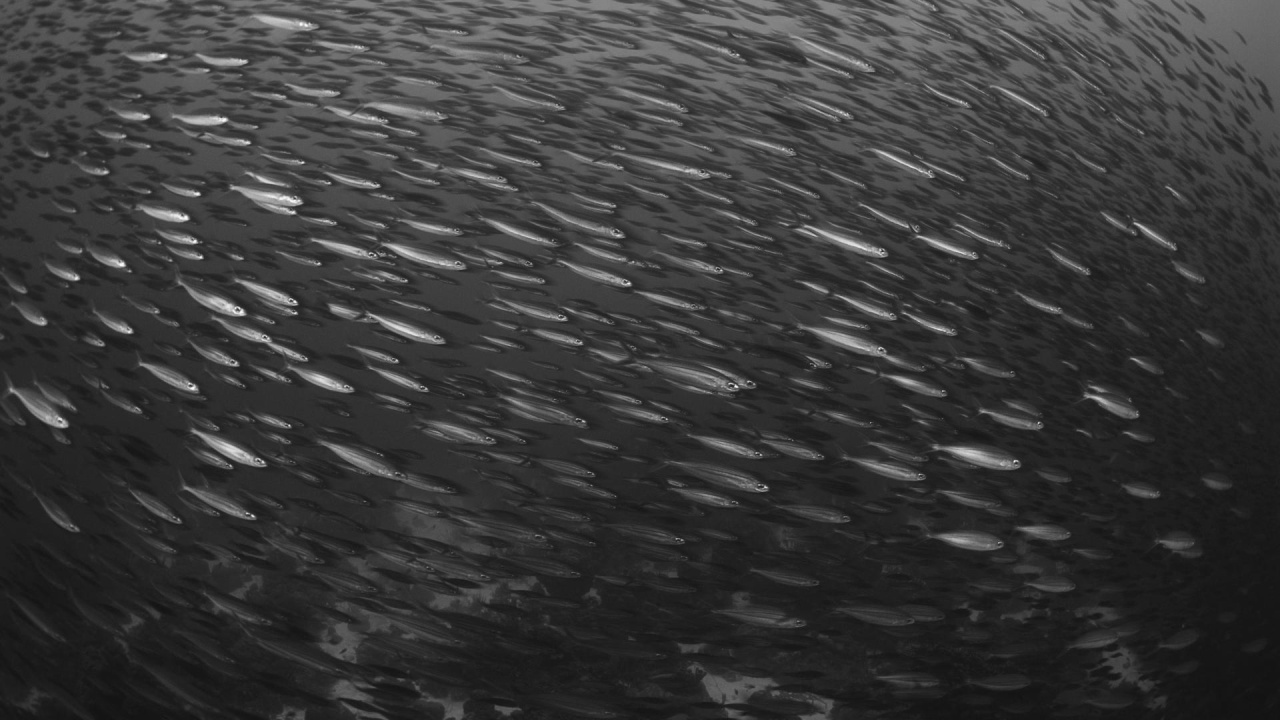

In [181]:
shoal = Image.open('img/school.jpg')
shoal= shoal.convert("L")
fish = Image.open('img/fish1.png')
fish = fish.convert("L")
display(shoal)


### Our goal is to find this exact fish: 


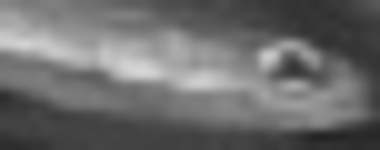

In [180]:
display(scale(fish,10))

### Correlation image:

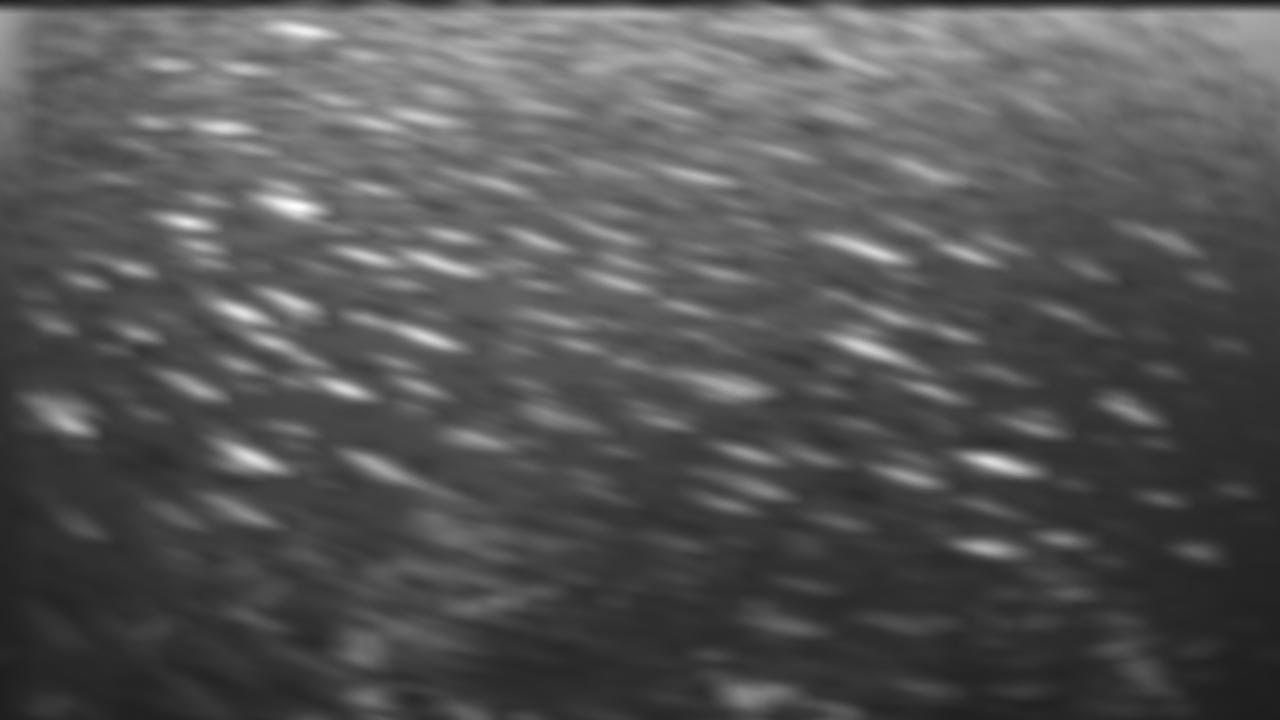

In [131]:
correlation = calc_correlation(shoal,fish)
display_correlation(correlation)

I am surprised, that this time it also looks only like a blurred image. I thought that maybe this time, we will see much biger difference between fishes and the ocean, but I suppose that correlation image might just always be useless.

### Let's try to find our match:

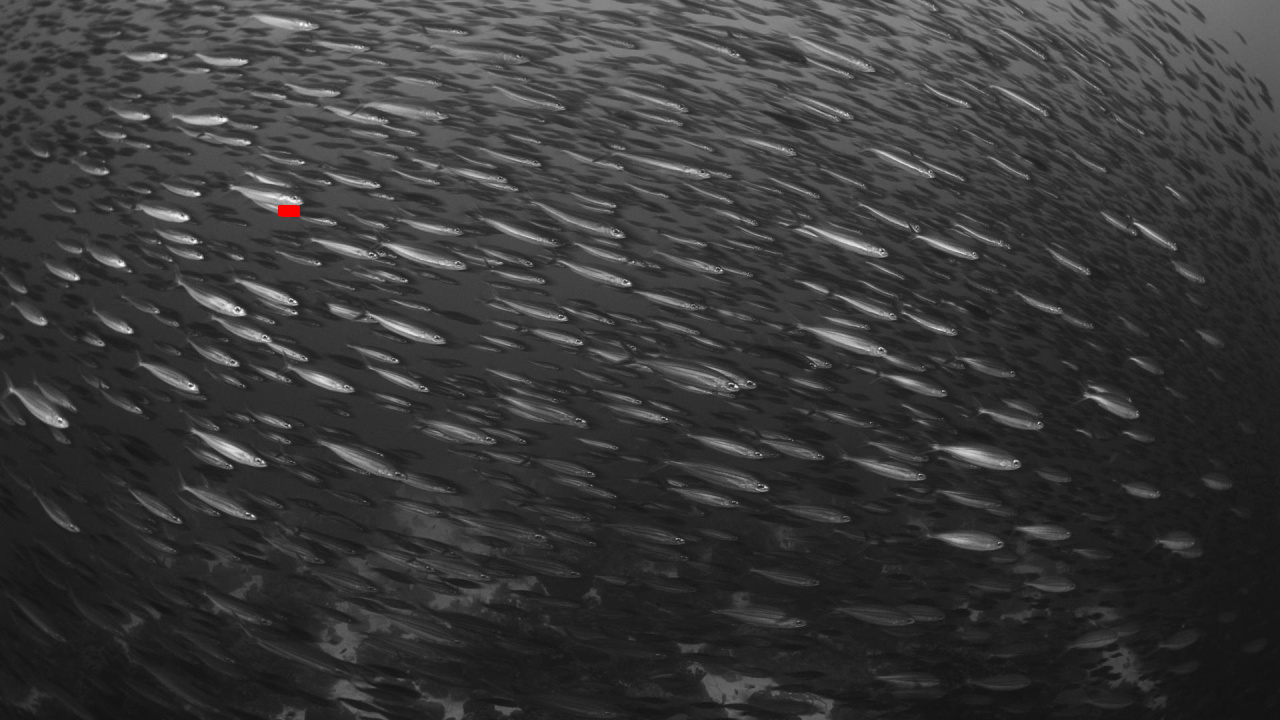

In [135]:
find_pattern(shoal,fish,certainty=0.99)

It does work! Let's test it for other certainty levels

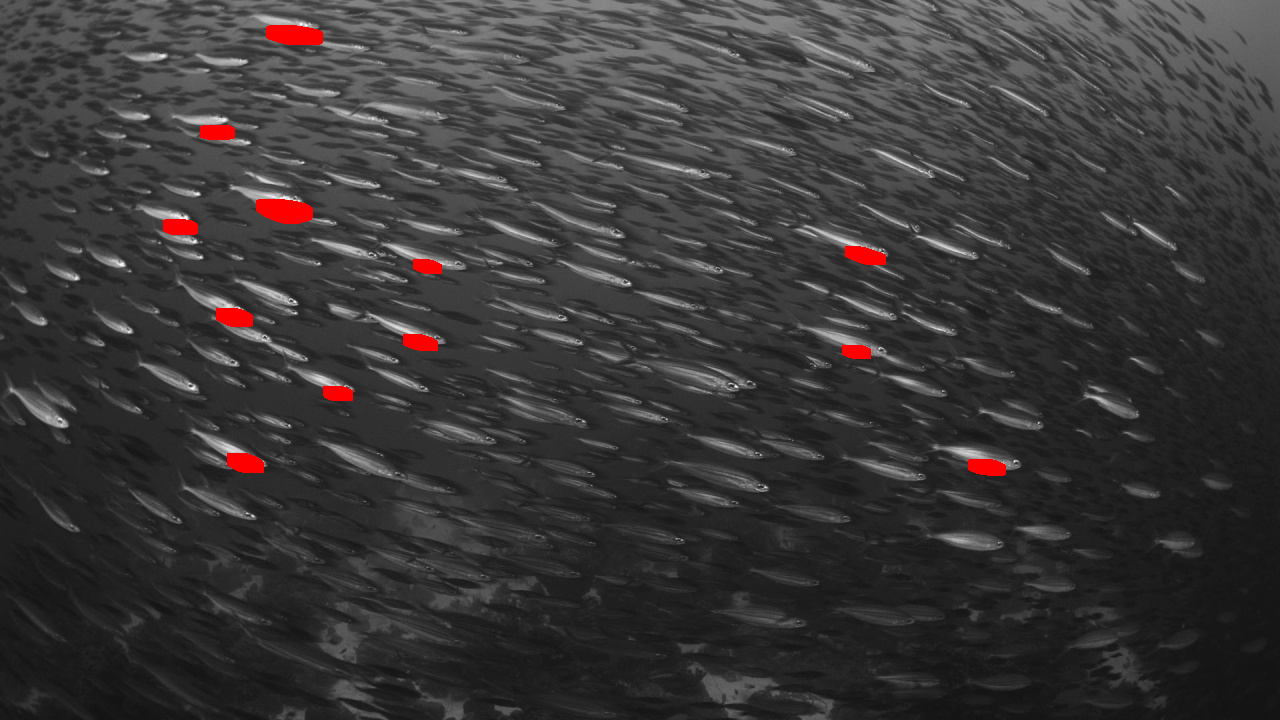

In [191]:
find_pattern(shoal,fish,certainty=0.80)

For certainty level at 0.80, it finds many matches (for me all those fishes are the same, aren't they?).  
The boundary betweeen one exact match and two matches this time lies between 0.93 and 0.94 certainty. 

## Conclusions 

DFT can be used with great succes for template matching algorithms. Altough it has some disadvantages it is easy and simple way to find a given template in any kind of image, not only text. In next task, I'll try to implement the whole OCR using this method. Let's see how it works out..

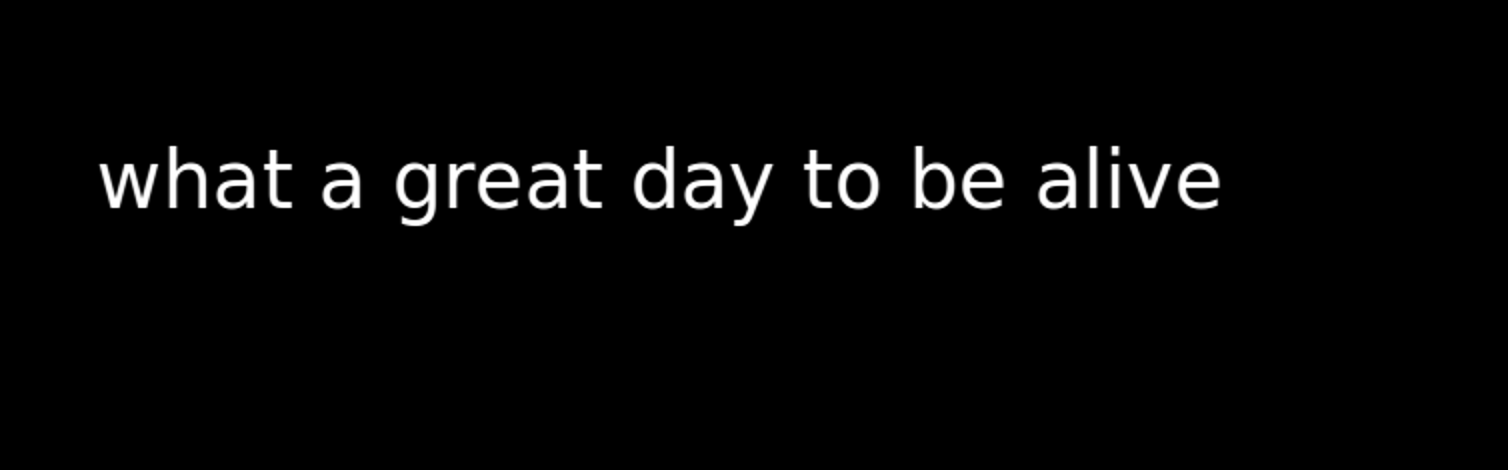

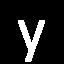

In [37]:
example = Image.open('img/example2.png')
example = scale(example,2)
example = ImageOps.invert(example.convert("L"))
a_letter = Image.open('resources/fonts/calibri_letters/y.png')
a_letter = ImageOps.invert(a_letter.convert("L"))
display(example)
display(a_letter)

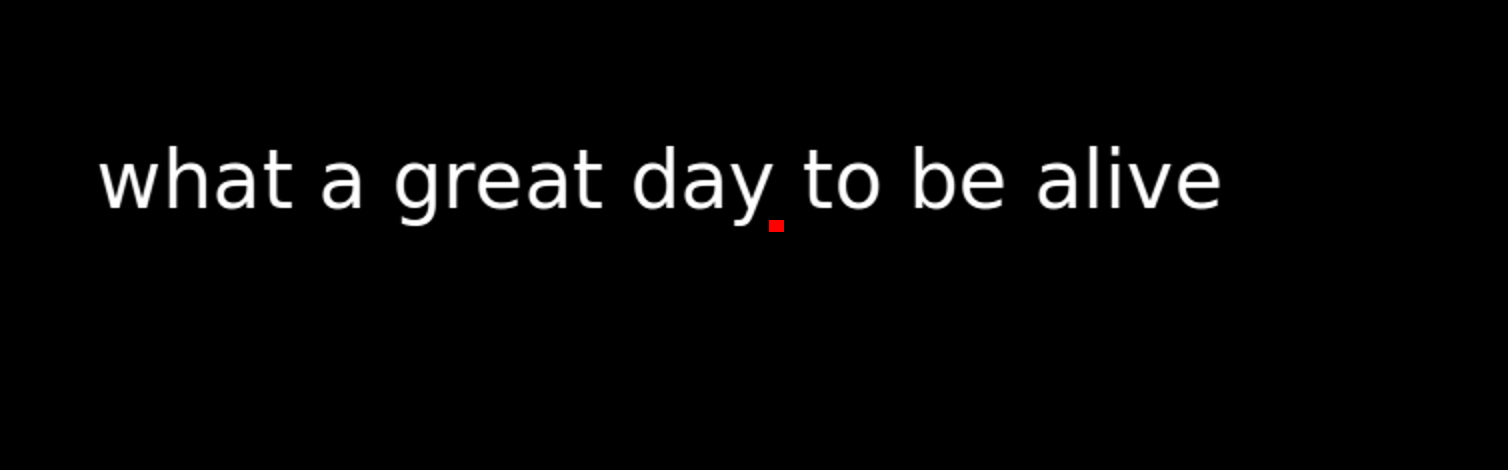

In [38]:
find_pattern(example,a_letter,0.98)